# Network Architecture Design

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [29]:
import os, sys, time, datetime, random
from pathlib import Path
from warnings import warn
from tqdm import tqdm, tnrange, tqdm_notebook
import pickle as pkl
import gc

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, OrderedDict
import cv2
from PIL import Image

In [ ]:
import torch as t
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import torchvision as tv

In [156]:
mpl.rcParams.update({'font.size': 14})
CMAP = plt.get_cmap('rainbow')

In [8]:
IMAGES_PATH = Path(r'../annotator/sampled_frames')
ANNOTATIONS = Path(r'../annotator/annotation_data/Default-Project27Jul2019_17h55m13s_export.csv')

## Annotations EDA

In [45]:
data = pd.read_csv(ANNOTATIONS, skiprows=9)
data = pd.DataFrame({
    'file': [f[2:-2] for f in data['file_list']],
    'x': [ float(sc[1:-1].split(',')[1]) for sc in data['spatial_coordinates'] ],
    'y': [ float(sc[1:-1].split(',')[2]) for sc in data['spatial_coordinates'] ],
    'dx': [ float(sc[1:-1].split(',')[3]) for sc in data['spatial_coordinates'] ],
    'dy': [ float(sc[1:-1].split(',')[4]) for sc in data['spatial_coordinates'] ]
})

print(data.shape)
data.head()

(630, 5)


,file,x,y,dx,dy
0,20190520_105429_1080.png,411.896,619.069,36.776,20.840
1,20190520_105429_1080.png,197.367,608.036,57.616,42.906
2,20190520_105429_1080.png,89.489,620.295,71.101,36.777
3,20190520_105429_1080.png,85.812,655.846,46.583,18.388
4,20190520_105429_1080.png,51.487,673.008,58.842,22.066


In [117]:
invalid_size = np.logical_or(data.dx<=0, data.dy<=0)
print(f'Boxes with invalid size: {np.sum(invalid_size):d}')
data = data[np.logical_not(invalid_size)]

Boxes with invalid size: 5


In [155]:
print(f'Boxes with invalid position: {(data.x<0).sum()+(data.y<0).sum():d}')
data.loc[data.x<0, 'x'] = 0
data.loc[data.y<0, 'y'] = 0

Boxes with invalid position: 0


In [27]:
files = list(np.unique(data.file))
print(f'{len(files):d} files')
files[:3]

10


['20190520_105429_1080.png',
 '20190529_154953_1877.png',
 '20190608_155249_shavuot.eve_1876.png']

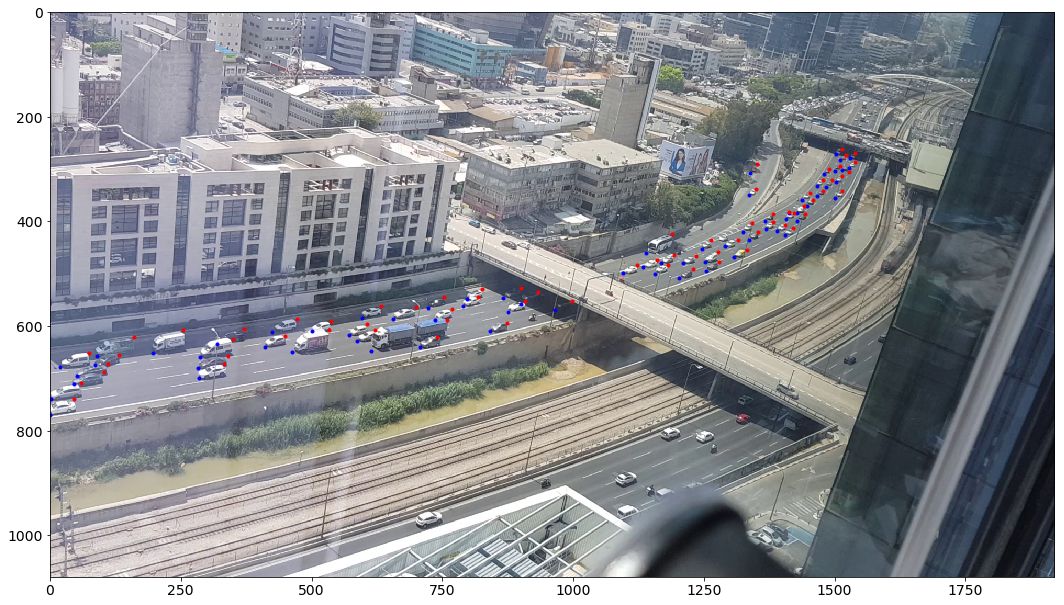

In [51]:
image = Image.open(IMAGES_PATH/files[0])
ids = data.file == files[0]

plt.figure(figsize=(18,12))
plt.imshow(image)
plt.plot(data.x[ids],              data.y[ids]+data.dy[ids], 'b.')
plt.plot(data.x[ids]+data.dx[ids], data.y[ids],              'r.');

It can be seen that in older videos the camera was positioned slightly differently:

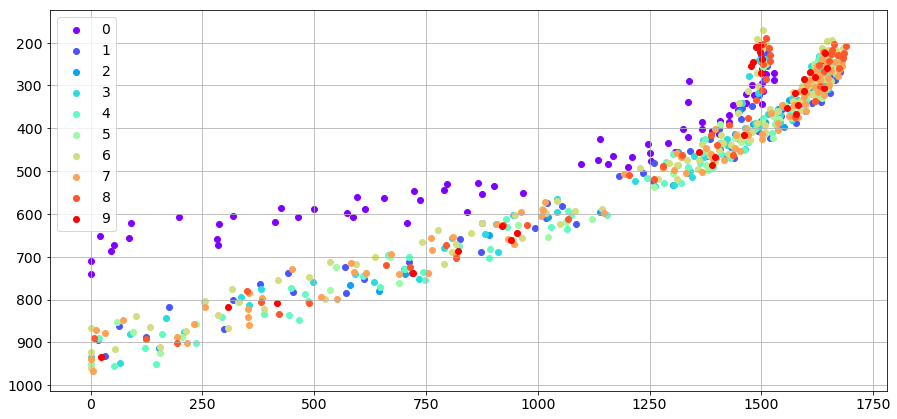

In [162]:
# plot all cars locations per image

COLORS = [CMAP(i)[:3] for i in np.linspace(0, 1, len(files))]
plt.figure(figsize=(15,7))

for i,f in enumerate(files):
    plt.scatter(data.x[data.file==f], data.y[data.file==f], color=COLORS[i], label=i)
plt.gca().invert_yaxis()
plt.grid()
plt.legend();

Most vehicles are of size 20-50 pixels (i.e. 400-2500 pixels^2), mostly depending on their distance from the camera:

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


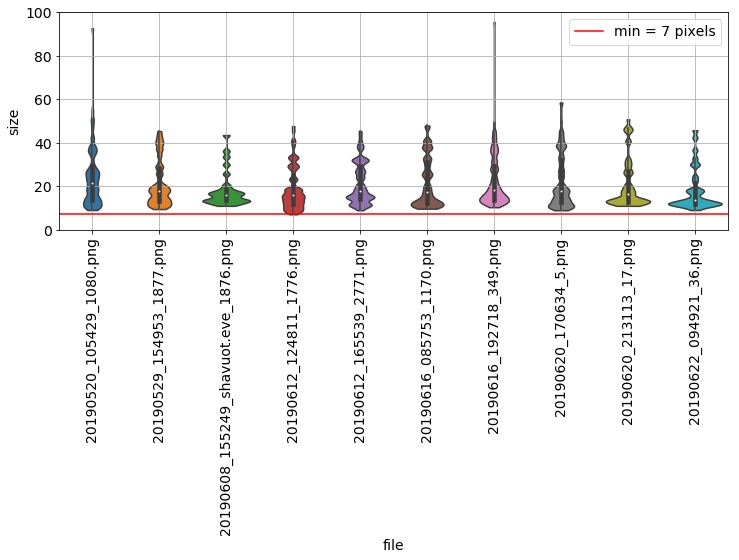

In [131]:
data['size'] = np.sqrt(data.dx * data.dy)

plt.figure(figsize=(12,4))
sns.violinplot('file', 'size', data=data, bw=0.1, cut=0)
plt.axhline(np.min(data['size']), color='r', label=f'min = {np.min(data["size"]):.0f} pixels')
plt.xticks(rotation=90)
plt.ylim((0,None))
plt.grid()
plt.legend();

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


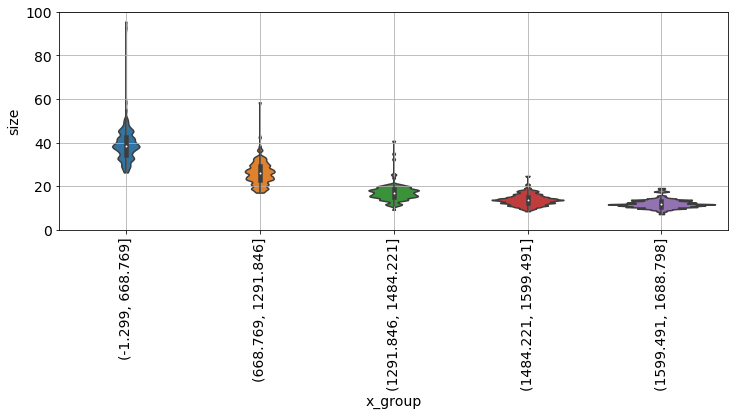

In [140]:
data['x_group'] = pd.qcut(data.x, 5)
plt.figure(figsize=(12,4))
sns.violinplot('x_group', 'size', data=data, bw=0.1, cut=0)
plt.xticks(rotation=90)
plt.ylim((0,None))
plt.grid()

## Get feature-extractor from pre-trained Resnet34

In [276]:
W,H = image.size
W,H

(1920, 1080)

In [167]:
model = tv.models.resnet34(pretrained=True)

In [226]:
len(list(model.named_children()))

10

In [ ]:
X = t.tensor(np.array(image))
print(X.shape)
X = X.unsqueeze(0)
print(X.shape)
X = X.permute(0,1,2,3)
print(X.shape)
X = X.permute(0,3,1,2)
print(X.shape)
# should be NCHW
X = X.type('torch.FloatTensor')
X = Variable(torch.Tensor(X))
# layer(X).shape

In [224]:
layers = model.children()
tmp = X
print(tmp.shape)
for i,layer in enumerate(layers):
    print(i,layer)
    tmp = layer(tmp)
    print(tmp.shape)
    
# Note: there occured a dimension error in a late layer which will not be used anyway.
# I couldn't find the source of the error, but since the layer won't be used, I hope it won't be relevant.

torch.Size([1, 3, 1080, 1920])
0 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
torch.Size([1, 64, 540, 960])
1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([1, 64, 540, 960])
2 ReLU(inplace)
torch.Size([1, 64, 540, 960])
3 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
torch.Size([1, 64, 270, 480])
4 Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

RuntimeError: size mismatch, m1: [512 x 1], m2: [512 x 1000] at c:\a\w\1\s\tmp_conda_3.6_091443\conda\conda-bld\pytorch_1544087948354\work\aten\src\th\generic/THTensorMath.cpp:940

Desired size (1080x1920)/8 = 135x240 was achieved after layer number 5 (and happened to be exact). Thus:

In [225]:
conv = nn.Sequential(*list(model.children())[:6])
for param in res50_conv.parameters():
    param.requires_grad = False
conv

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [227]:
out = conv(X)

torch.Size([1, 128, 135, 240])

In [239]:
map_h,map_w = out.shape[-2:]
out.shape

torch.Size([1, 128, 135, 240])

In [236]:
feature_size = image.size[0] // out.shape[-1]
feature_size

8

## Anchor boxes

Change boxes format to y1,x1,y2,x2:

In [164]:
data['y1'] = data['y']
data['x1'] = data['x']
data['y2'] = data['y'] + data['dy']
data['x2'] = data['x'] + data['dx']

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [298]:
anchor_scales = (3, 6, 12)
anchor_ratios = (0.5, 1, 2)

In [273]:
box_y0 = feature_size * np.arange(map_h) + feature_size/2
box_x0 = feature_size * np.arange(map_w) + feature_size/2
box_center = [(y0,x0) for y0 in box_y0 for x0 in box_x0]

anchors = np.zeros((map_h * map_w * len(anchor_ratios) * len(anchor_scales), 4))
print(anchors.shape)

index = 0
for y0,x0 in tqdm_notebook(box_center):
    for i,ratio in enumerate(anchor_ratios):
        for j,scale in enumerate(anchor_scales):
            h = feature_size * scale * np.sqrt(ratio)
            w = feature_size * scale * np.sqrt(1./ratio)
            anchors[index, 0] = y0 - h / 2.
            anchors[index, 1] = x0 - w / 2.
            anchors[index, 2] = y0 + h / 2.
            anchors[index, 3] = x0 + w / 2.
            index += 1

(291600, 4)


In [315]:
valid_anchor_ids = np.where((anchors[:,0]>=0) & (anchors[:,2]<=H) & (anchors[:,1]>=0) & (anchors[:,3]<=W))[0]
valid_anchors = anchors[valid_anchor_ids, :]
len(valid_anchors)

268870

In [429]:
# anchors locations for later labeling
base_h = valid_anchors[:, 2] - valid_anchors[:, 0]
base_w = valid_anchors[:, 3] - valid_anchors[:, 1]
base_y0 = valid_anchors[:, 0] + 0.5 * base_h
base_x0 = valid_anchors[:, 1] + 0.5 * base_w

# force positive size
eps = np.finfo(base_h.dtype).eps
base_h = np.maximum(base_h, eps)
base_w = np.maximum(base_w, eps)

### Receptive field analysis

- **Every cell in a feature map stands for `nxn` pixels** in the original input (with `n` increasing, for example, in pooling-layers and in conv-layers with strides).
- **Every conv-layer with kernel `kxk`** increases the receptive radius ("radius" here means half-edge of a square...) by `((k-1)/2) * n`.
- Similarly, **grouping kxk cells into an anchor box** increases their shared receptive radius by `((k-1)/2) * n`.
- The **receptive radius `R`** of a cell in a feature map is the sum of increases over the layers.
- The **receptive field** of a cell usually refers to a square of size rxr around the cell, with `r = 1 + 2*R`.

In our case:
- The first conv layer with kernel 7x7 increases the receptive radius by `3`.
- The next sequence of 6 layers with kernels 3x3 increases the radius by `(6 layers * 1 * 4) = 24`.
- The next sequence of 8 layers with kernels 3x3 increases the radius by `(8 layers * 1 * 8) = 64`.
- The smallest anchor boxes consist of 3x3 cells (TODO understand how it works with ratio!=1...), increasing the radius by `8`.

Hence, **the receptive field of the smallest anchor boxes is of size `r = 1 + 2*(3+24+64+8) = 199`.
We can see below that this is a very reasonable range considering the distances in the images.**


_____________________

TODO in addition to the feature map, add the anchor box location to the NN. also consider using GBM on top of the feature map?

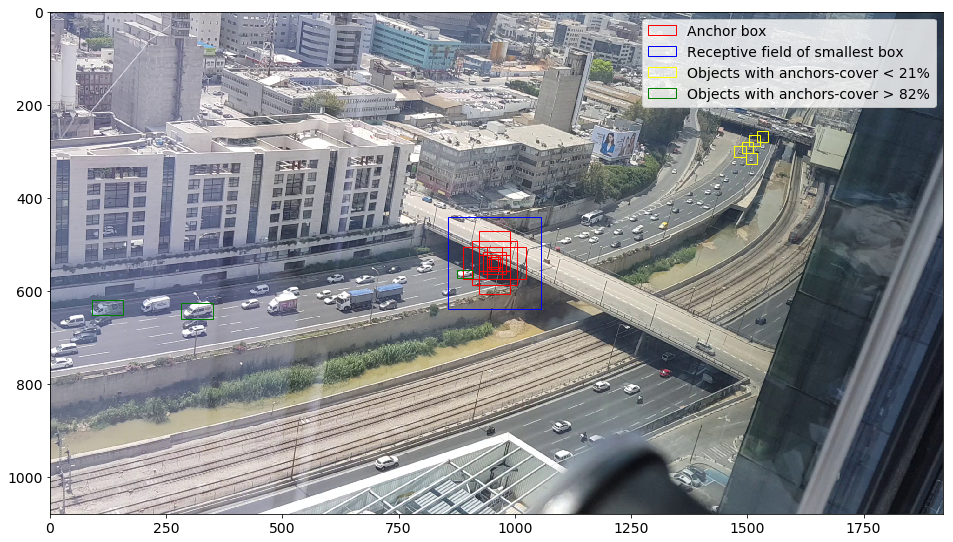

In [415]:
plt.figure(figsize=(16,10))

plt.imshow(image)

ax = plt.gca()
for i in range(anchors.shape[0]//2-9, anchors.shape[0]//2):
    ax.add_patch(mpl.patches.Rectangle((anchors[i,1],anchors[i,0]), (anchors[i,3]-anchors[i,1]), (anchors[i,2]-anchors[i,0]),
                                       color='red', fill=False, label='Anchor box' if i==anchors.shape[0]//2-9 else None))

# Receptive field
ax.add_patch(mpl.patches.Rectangle(((anchors[i,3]+anchors[i,1])/2-99, (anchors[i,2]+anchors[i,0])/2-99), 199, 199,
                                   color='blue', fill=False, label='Receptive field of smallest box'))

# Objects with worst/best covers by anchors (calculated below)
bad_covers = valid_anchors[best_anchor_per_obj[np.argsort(best_iou_per_obj)[:5]]]
max_bad_cover = np.sort(best_iou_per_obj)[4]
for cover in bad_covers:
    ax.add_patch(mpl.patches.Rectangle((cover[1],cover[0]), (cover[3]-cover[1]), (cover[2]-cover[0]),
                                       color='yellow', fill=False,
                                       label=f'Objects with anchors-cover < {100*max_bad_cover:.0f}%' if (cover==bad_covers[0]).all() else None))
good_covers = valid_anchors[best_anchor_per_obj[np.argsort(best_iou_per_obj)[-3:]]]
min_good_cover = np.sort(best_iou_per_obj)[-3]
for cover in good_covers:
    ax.add_patch(mpl.patches.Rectangle((cover[1],cover[0]), (cover[3]-cover[1]), (cover[2]-cover[0]),
                                       color='green', fill=False,
                                       label=f'Objects with anchors-cover > {100*min_good_cover:.0f}%' if (cover==good_covers[0]).all() else None))

ax.legend();

## Labels assignment

In [420]:
n_images = len(files)

Assign target labels to anchor boxes:

In [388]:
boxes = data.groupby('file').apply(
    lambda d: np.asarray([list(d.iloc[i,-4:]) for i in range(len(d))], dtype=np.float32))

In [390]:
# Note: ious could be computed more efficiently using concepts of spatial search:
#       we don't need to compare every object to every anchor, but only to anchors in its surrounding.

# Source: https://medium.com/@venuktan/vectorized-intersection-over-union-iou-in-numpy-and-tensor-flow-4fa16231b63d

def get_ious(boxes1, boxes2):
    y11, x11, y12, x12 = np.split(boxes1, 4, axis=1)
    y21, x21, y22, x22 = np.split(boxes2, 4, axis=1)
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    return iou

In [391]:
%time ious = [get_ious(valid_anchors, boxes_i) for boxes_i in boxes]

Wall time: 11.8 s


In [395]:
ious[0].shape

(268870, 67)

In [454]:
valid_labels = np.empty((len(valid_anchors),n_images), dtype=np.int32)
valid_labels.fill(-1) # -1 means neither full object nor empty - so don't use to train
locations = np.empty((valid_anchors.shape[0], valid_anchors.shape[1], n_images), dtype=np.float64)
locations.fill(0)


for i in tnrange(len(np.unique(data['file']))):
    
    # find best anchor for each actual object
    best_anchor_per_obj = ious[i].argmax(axis=0)
    #print(best_anchor_per_obj.shape)
    best_iou_per_obj = ious[i][best_anchor_per_obj, np.arange(ious[i].shape[1])]
    #print(best_iou_per_obj.shape)

    best_anchors_per_obj = np.where(ious[i]==best_iou_per_obj)[0] # multiple anchors may be best for a single obj
    #print(best_anchors_per_obj.shape)
    
    # find best iou for each anchor
    best_obj_per_anchor = ious[i].argmax(axis=1)
    best_iou_per_anchor = ious[i][np.arange(len(valid_anchors)), best_obj_per_anchor]
    #print(best_iou_per_anchor.shape)
    
    # set labels
    valid_labels[best_iou_per_anchor <  0.3, i] = 0 # no-object target
    valid_labels[best_iou_per_anchor >= 0.7, i] = 1 # object target
    valid_labels[best_anchors_per_obj, i] = 1       # object target
    
    # best objs locations
    obj_h = boxes[i][best_obj_per_anchor, 2] - boxes[i][best_obj_per_anchor, 0]
    obj_w = boxes[i][best_obj_per_anchor, 3] - boxes[i][best_obj_per_anchor, 1]
    obj_y0 = boxes[i][best_obj_per_anchor, 0] + 0.5 * base_h
    obj_x0 = boxes[i][best_obj_per_anchor, 1] + 0.5 * base_w

    # relative locations within anchors
    dy = (obj_y0 - base_y0) / base_h
    dx = (obj_x0 - base_x0) / base_w
    dh = np.log(obj_h / base_h)
    dw = np.log(obj_w / base_w)
    locations[:,:,i] = np.vstack((dy, dx, dh, dw)).transpose()


print(locations.shape)
print(valid_labels.shape)
Counter(valid_labels.flatten())


(268870, 4, 10)
(268870, 10)


Counter({0: 2671575, 1: 1078, -1: 16047})

In [455]:
# project onto all anchors (including invalid ones that get out of the margins)

anchor_labels = np.empty((len(anchors), n_images), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[valid_anchor_ids, :] = valid_labels

anchor_locations = np.empty((anchors.shape[0], anchors.shape[1], n_images), dtype=locations.dtype)
anchor_locations.fill(0)
anchor_locations[valid_anchor_ids, :, :] = locations

print(anchor_labels.shape, anchor_locations.shape)
Counter(anchor_labels.flatten())

(291600, 10) (291600, 4, 10)


Counter({-1: 243347, 0: 2671575, 1: 1078})

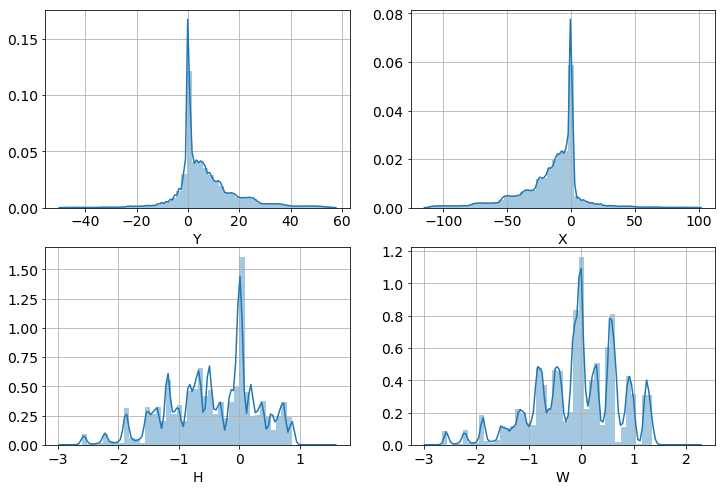

In [459]:
_, axs = plt.subplots(2,2, figsize=(12,8))

for i in range(4):
    ax = axs[i//2, i%2]
    sns.distplot(anchor_locations[:,i,:].flatten(), ax=ax)
    ax.set_xlabel(('Y','X','H','W')[i])
    ax.grid()

In [461]:
# repeat for first image - find best anchor for each actual object (to plot above)
best_anchor_per_obj = ious[0].argmax(axis=0)
best_iou_per_obj = ious[0][best_anchor_per_obj, np.arange(ious[0].shape[1])]

print(best_anchor_per_obj.shape, best_iou_per_obj.shape)

(67,) (67,)


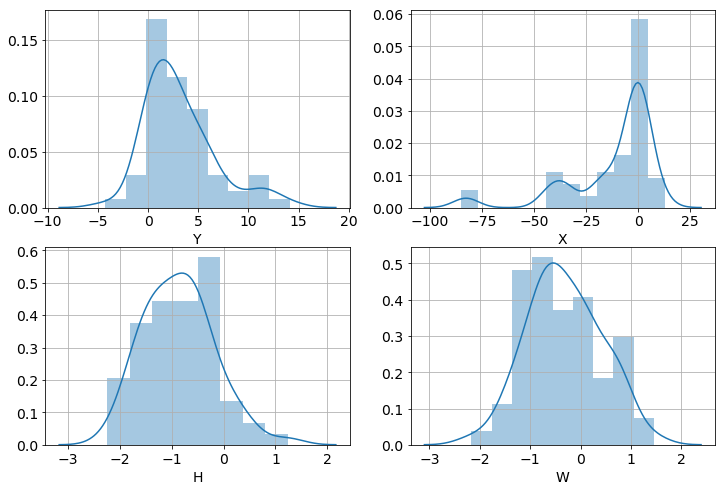

In [462]:
# TODO DEBUG why not H,W<0 and not 0<=X,Y<=1

_, axs = plt.subplots(2,2, figsize=(12,8))

for i in range(4):
    ax = axs[i//2, i%2]
    sns.distplot(anchor_locations[best_anchor_per_obj,i,0].flatten(), ax=ax)
    ax.set_xlabel(('Y','X','H','W')[i])
    ax.grid()

Note: when training with batch_size, each batch will be taken from a single image, and will sample `n_pos=min(n_objs,batch_size/2)` anchors with value +1 and `batch_size-n_pos` anchors with value 0.